In [1]:

from collections import Counter
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from pybaseball import playerid_lookup
import time

In [2]:
data = pd.read_csv("statcast_data_2016_2023.csv")
data["year"] = pd.to_datetime(data["game_date"]).dt.year
data = data[data["year"] == 2023]
pitcher_counts = data["pitcher"].value_counts()

/var/folders/6_/_y8v0gjj4sz2yhr732yn3_tc0000gn/T/ipykernel_35139/925024288.py:1: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("statcast_data_2016_2023.csv")


Time taken: 3.6083450317382812 seconds


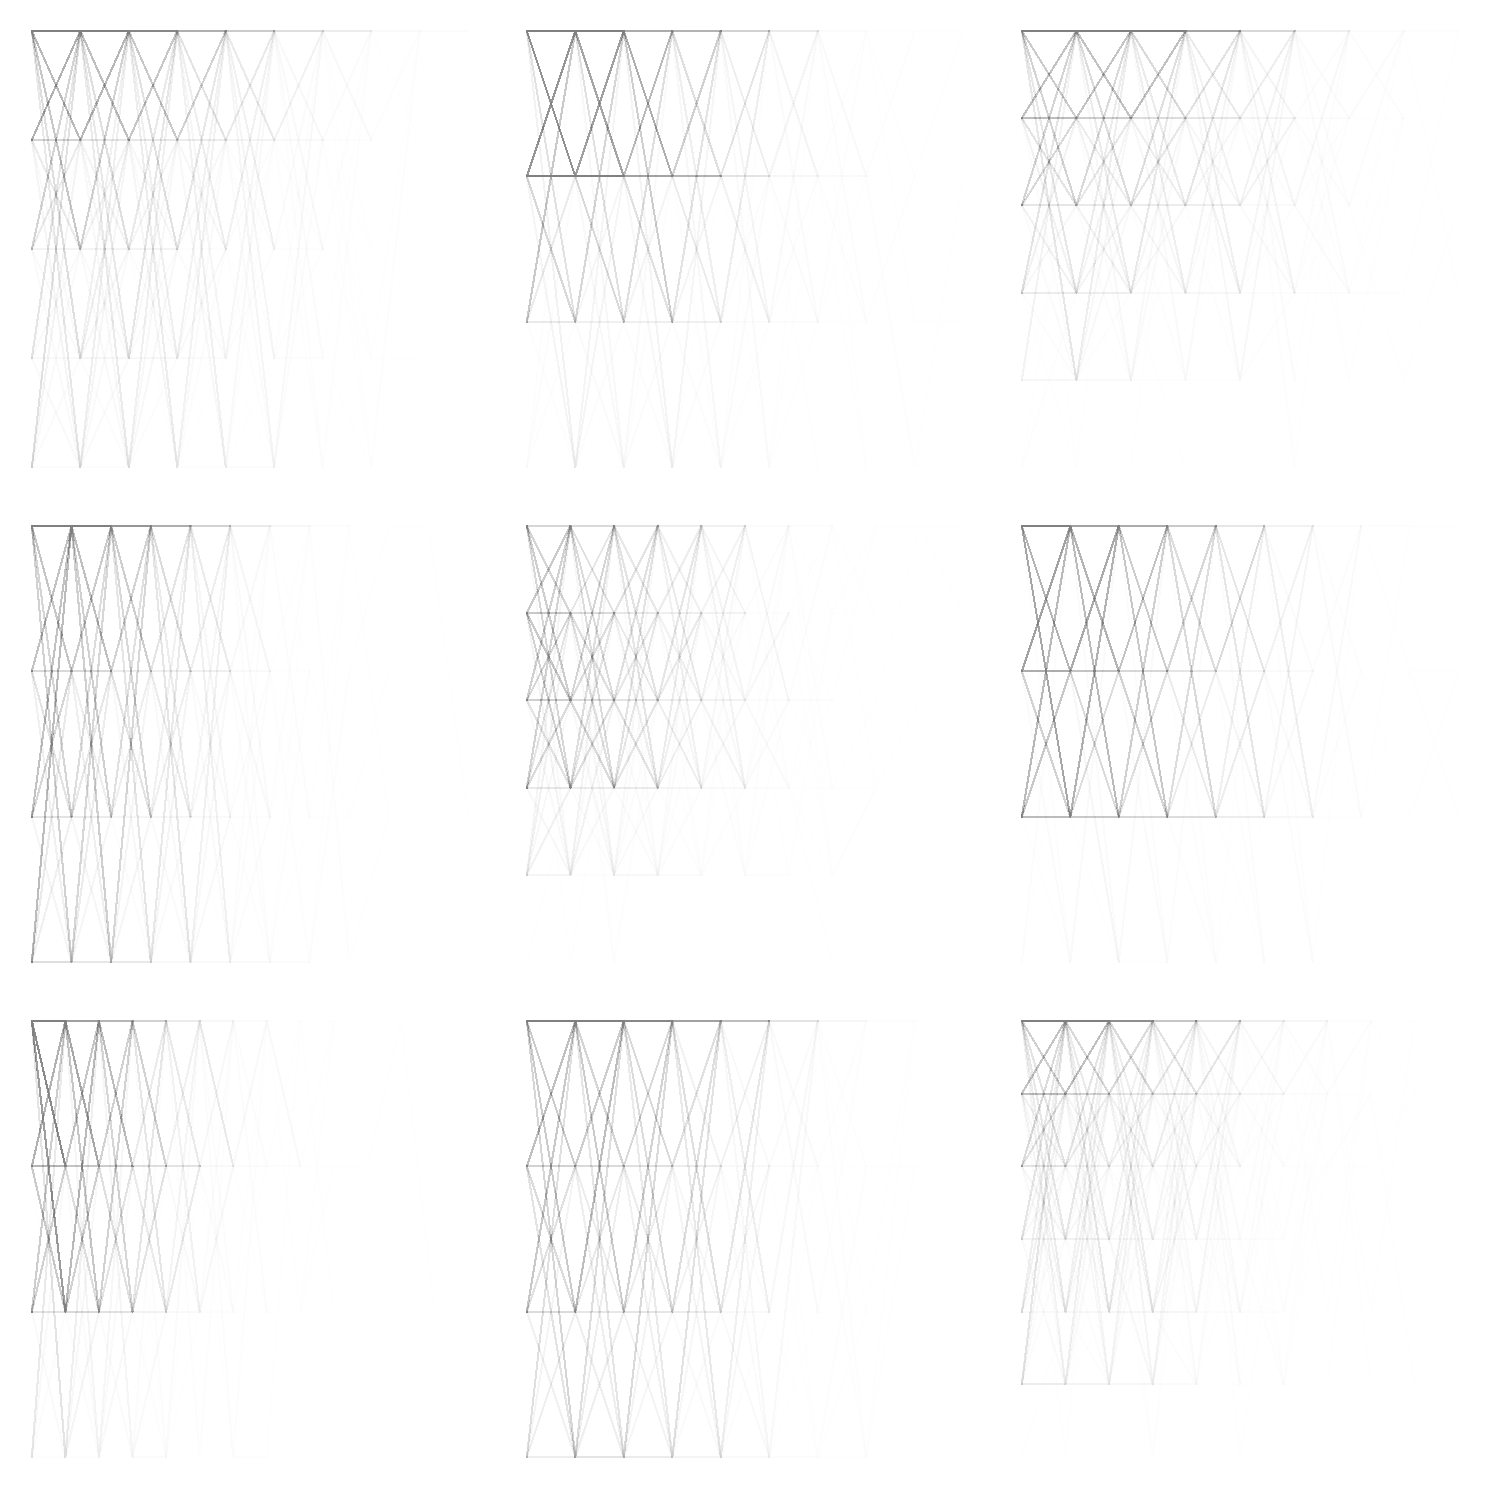

In [3]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# To ensure that data isn't overwritten
original_data = data.copy()

for i in range(3):
    for j in range(3):
        selected_pitcher = pitcher_counts.index[i * 3 + j]
        pitcher_data = original_data[original_data["pitcher"] == selected_pitcher]
        pitching_sequences = pitcher_data[pitcher_data["pitch_type"].notnull()]

        # Initialize an empty list for pitch sequences
        pitch_sequences = []

        unique_games = pitching_sequences["game_pk"].unique()

        for game in unique_games:
            game_data = pitching_sequences[pitching_sequences["game_pk"] == game]
            at_bats = game_data["at_bat_number"].unique()
            for at_bat in at_bats:
                at_bat_data = game_data[game_data["at_bat_number"] == at_bat]
                pitch_sequence = at_bat_data["pitch_type"].values
                pitch_sequences.append(pitch_sequence)

        # Further processing and visualization as before...
        # Flatten the list to count overall frequencies
        all_pitches = [pitch for seq in pitch_sequences for pitch in seq]
        pitch_counts = Counter(all_pitches)

        # Assign an integer to each pitch, most common pitch gets the lowest integer
        pitch_map = {pitch: i for i, (pitch, _) in enumerate(pitch_counts.most_common())}

        # Transform sequences to their mapped integers
        transformed_sequences = [[pitch_map[pitch] for pitch in seq] for seq in pitch_sequences]
        # Plot each transformed sequence as a line
        for seq in transformed_sequences:
            axes[i, j].plot(range(len(seq)), seq, marker=None, linestyle='-', color="grey", alpha=1/256)

        # Adjust subplot axes directly
        axes[i, j].invert_yaxis()
        axes[i, j].axis('off')  # Consider removing this if you want labels/titles

plt.tight_layout()
plt.savefig("pitching_sequences_faint.png")

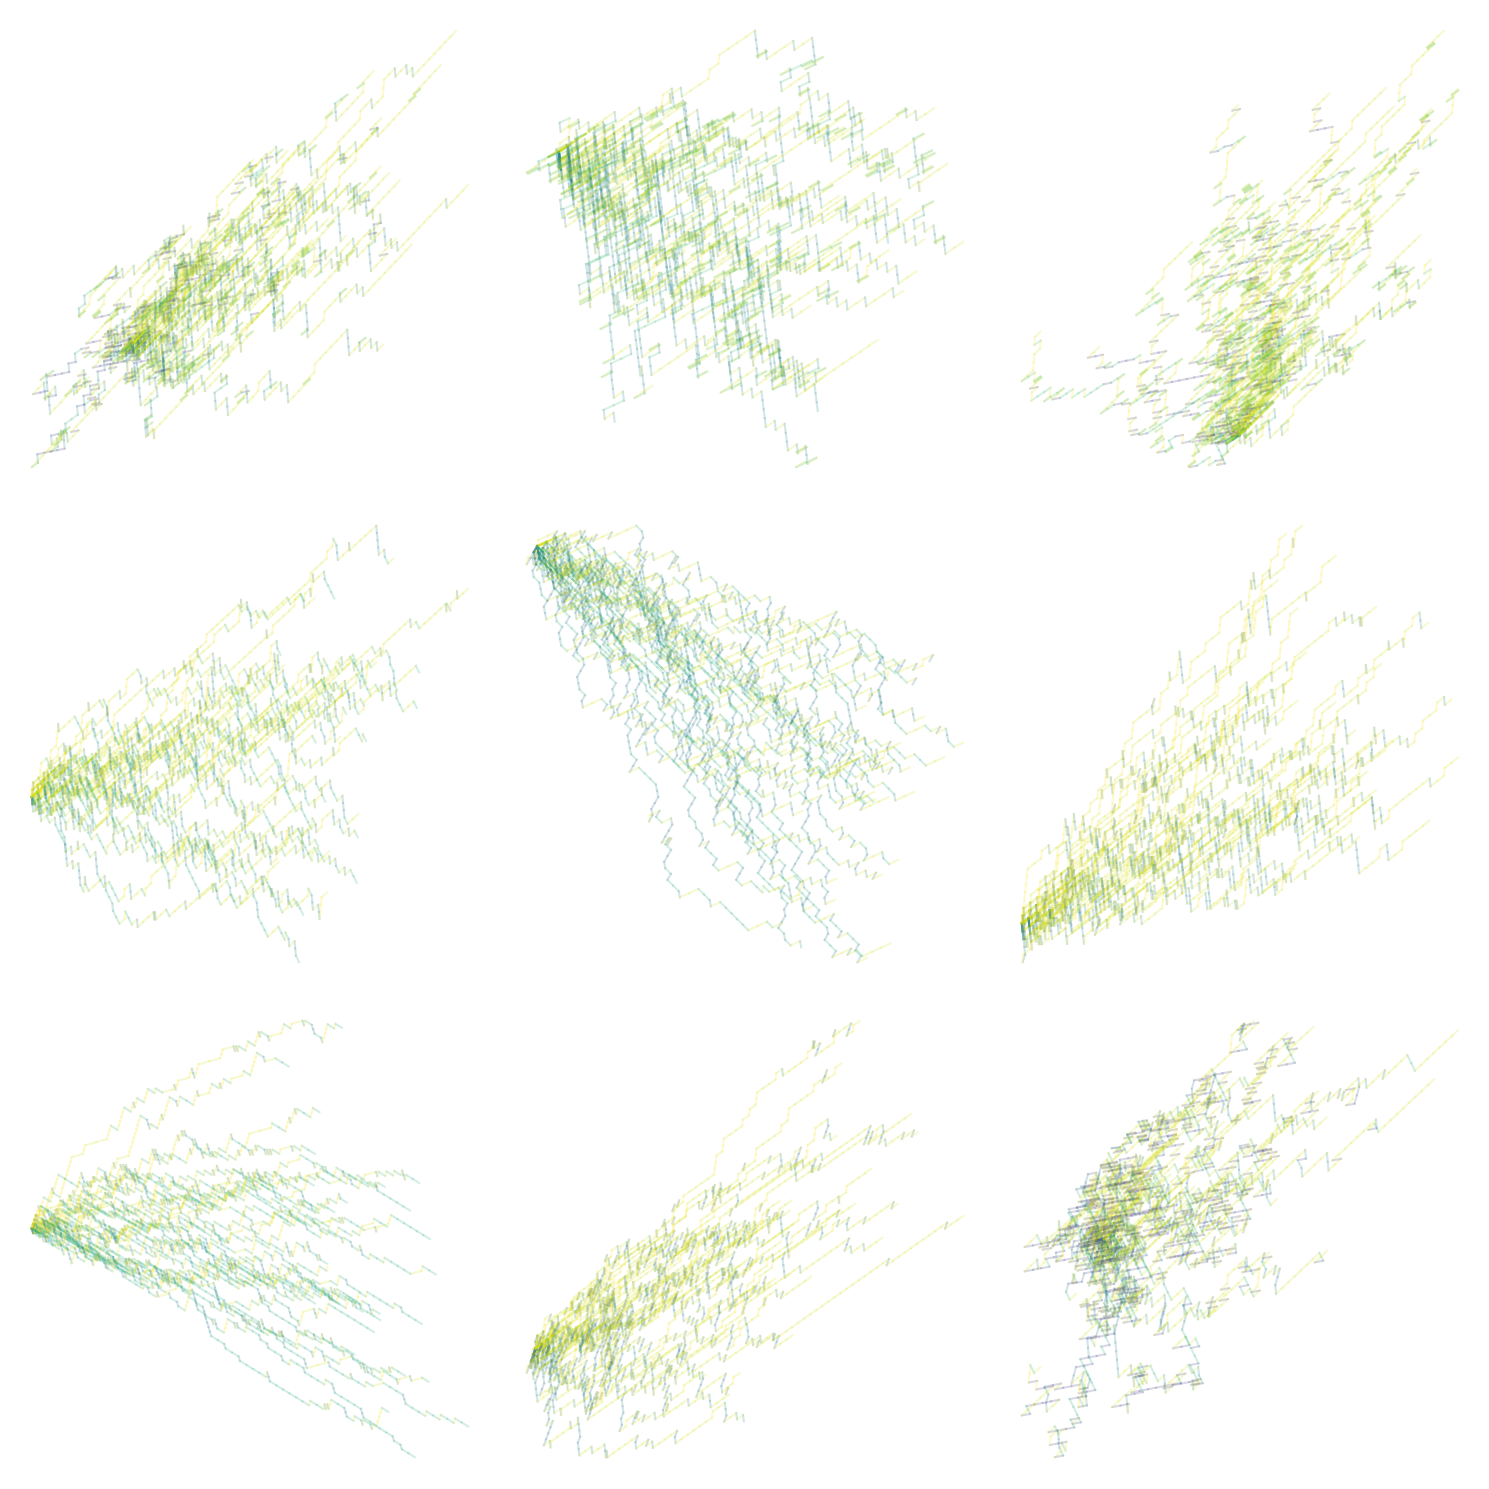

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'data' and 'pitcher_counts' are loaded as before

# Example pitch types and their assigned angles and colors
pitch_types = data["pitch_type"].dropna().unique()  # Ensure no NaN values

angles = np.linspace(0, 2 * np.pi, len(pitch_types), endpoint=False)
# Shuffle angles for even distribution
np.random.shuffle(angles)
colors = plt.cm.viridis(np.linspace(0, 1, len(pitch_types)))
np.random.shuffle(colors)


pitch_info = {pitch: (angle, color) for pitch, angle, color in zip(pitch_types, angles, colors)}

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i in range(3):
    for j in range(3):
        selected_pitcher = pitcher_counts.index[i * 3 + j]
        pitcher_data = data[data["pitcher"] == selected_pitcher]
        pitching_sequences = pitcher_data[pitcher_data["pitch_type"].notnull()]

        pitch_sequences = []

        unique_games = pitching_sequences["game_pk"].unique()

        for game in unique_games:
            game_data = pitching_sequences[pitching_sequences["game_pk"] == game]
            at_bats = game_data["at_bat_number"].unique()
            pitch_sequence = game_data["pitch_type"].values
            pitch_sequences.append(pitch_sequence)

            # for at_bat in at_bats:
            #     at_bat_data = game_data[game_data["at_bat_number"] == at_bat]
            #     pitch_sequence = at_bat_data["pitch_type"].values
            #     pitch_sequences.append(pitch_sequence)

        # For each sequence, calculate and plot the "walk"
        for seq in pitch_sequences:
            x, y = 0, 0  # Starting position
            last_x, last_y = x, y

            for pitch in seq:
                if pitch in pitch_info:
                    angle, color = pitch_info[pitch]
                    x += np.cos(angle)
                    y += np.sin(angle)
                    # Plot each segment individually
                    axes[i, j].plot([last_x, x], [last_y, y], marker=None, linestyle='-', color=color, alpha=0.2)
                    last_x, last_y = x, y  # Update last position

        # axes[i, j].set_xlim([-10, 10])  # Adjust as needed
        # axes[i, j].set_ylim([-10, 10])  # Adjust as needed
        axes[i, j].axis('off')

plt.tight_layout()
plt.savefig("pitching_sequences_radial_walk.png")


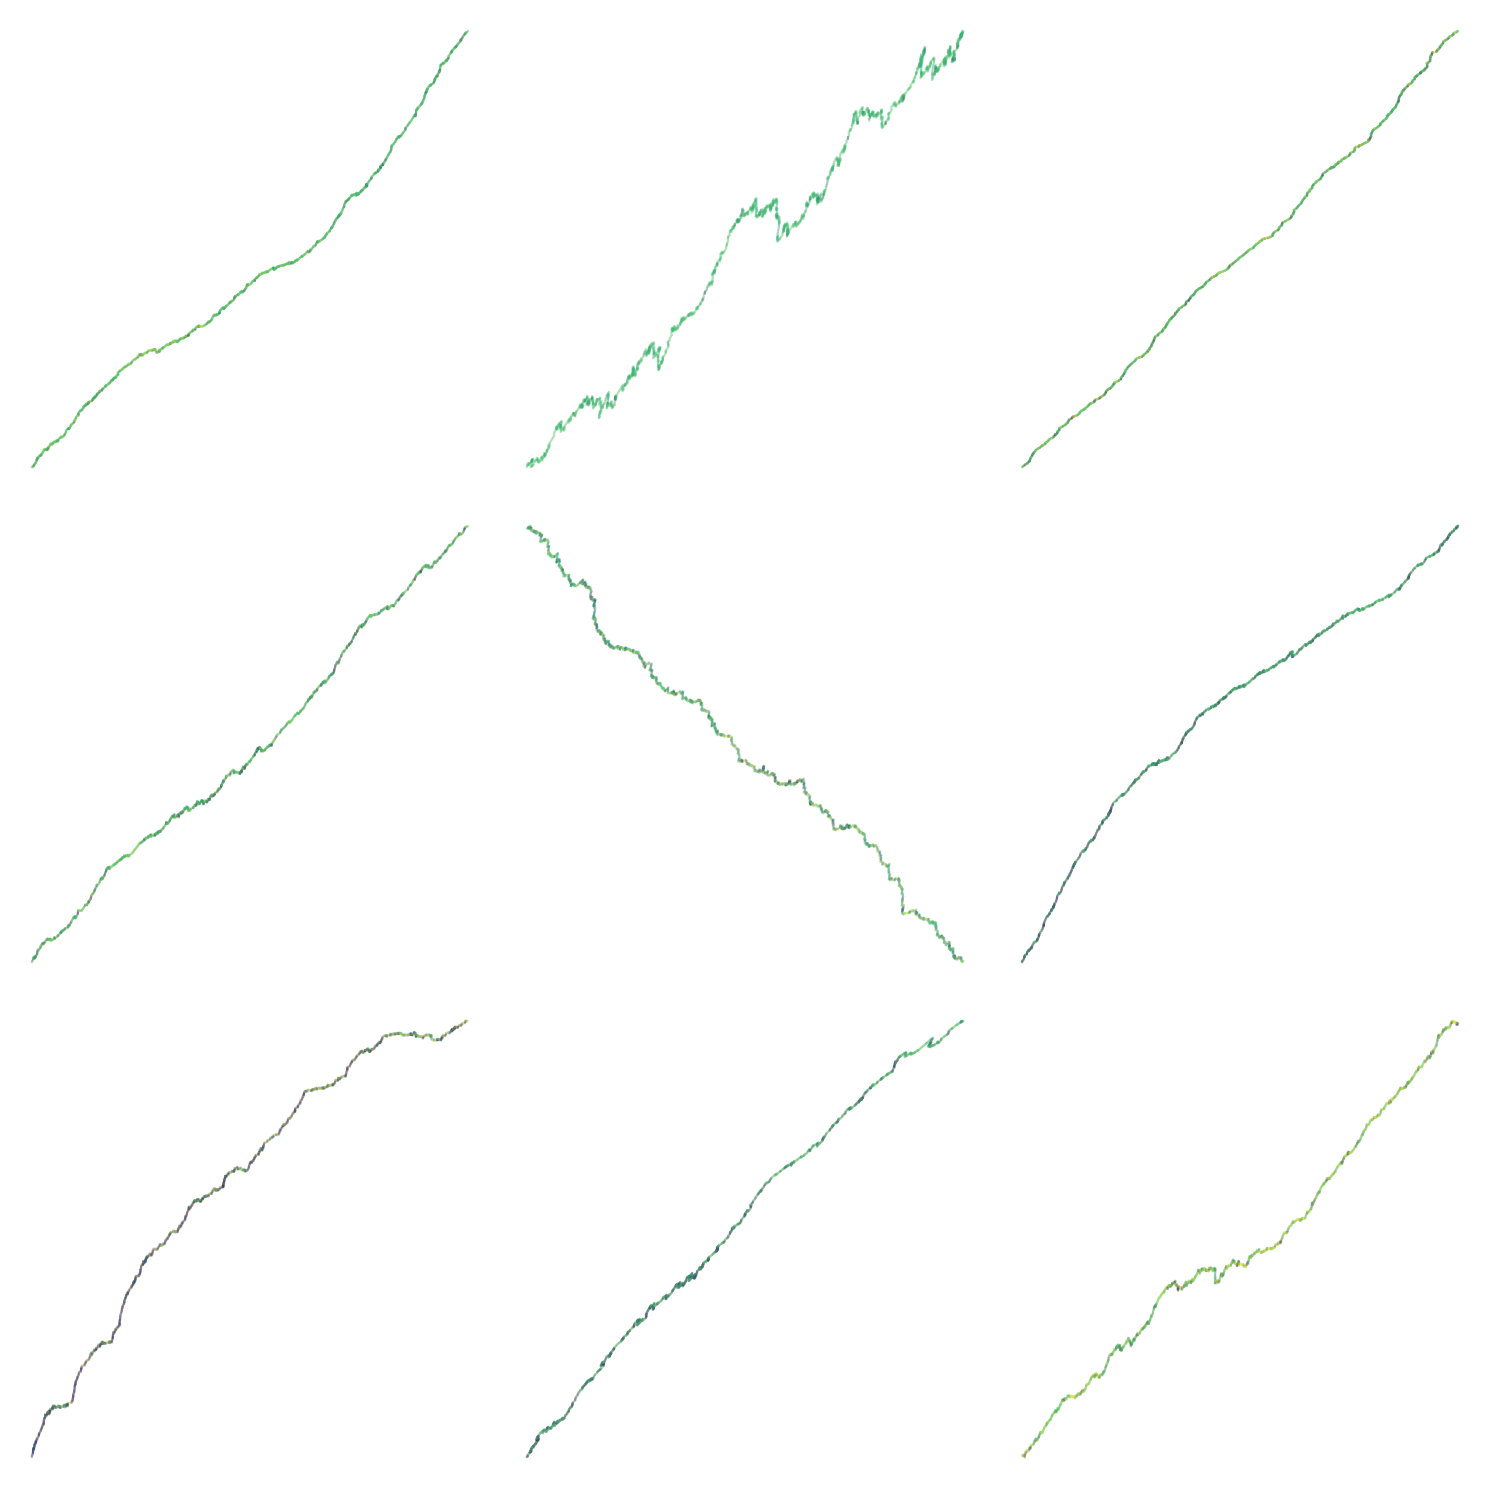

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'data' and 'pitcher_counts' are loaded as before

# Ensure no NaN values in pitch types
pitch_types = data["pitch_type"].dropna().unique()

# Generate evenly distributed angles and colors for each pitch type
angles = np.linspace(0, 2 * np.pi, len(pitch_types), endpoint=False)
np.random.shuffle(angles)  # Shuffle angles for an even distribution
colors = plt.cm.viridis(np.linspace(0, 1, len(pitch_types)))
np.random.shuffle(colors)  # Shuffle colors to match the shuffled angles

# Create a dictionary to map each pitch type to an angle and color
pitch_info = {pitch: (angle, color) for pitch, angle, color in zip(pitch_types, angles, colors)}

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i in range(3):
    for j in range(3):
        selected_pitcher = pitcher_counts.index[i * 3 + j]
        # Filter the dataset for the selected pitcher and ensure pitch_type is not null
        pitcher_data = data[(data["pitcher"] == selected_pitcher) & (data["pitch_type"].notnull())]

        # Extract pitch sequences as a single continuous sequence for the season
        pitch_sequence = pitcher_data["pitch_type"].values

        # Plot the "walk" for the whole season
        x, y = 0, 0  # Starting position
        last_x, last_y = x, y

        for pitch in pitch_sequence:
            if pitch in pitch_info:
                angle, color = pitch_info[pitch]
                x += np.cos(angle)  # Move in the direction determined by the pitch type's angle
                y += np.sin(angle)
                # Plot each segment individually with a specified color and transparency
                axes[i, j].plot([last_x, x], [last_y, y], marker=None, linestyle='-', color=color, alpha=0.2)
                last_x, last_y = x, y  # Update the last position for the next segment

        axes[i, j].axis('off')  # Turn off the axis for a cleaner look

plt.tight_layout()
plt.savefig("pitching_sequences_seasonal_radial_walk.png")


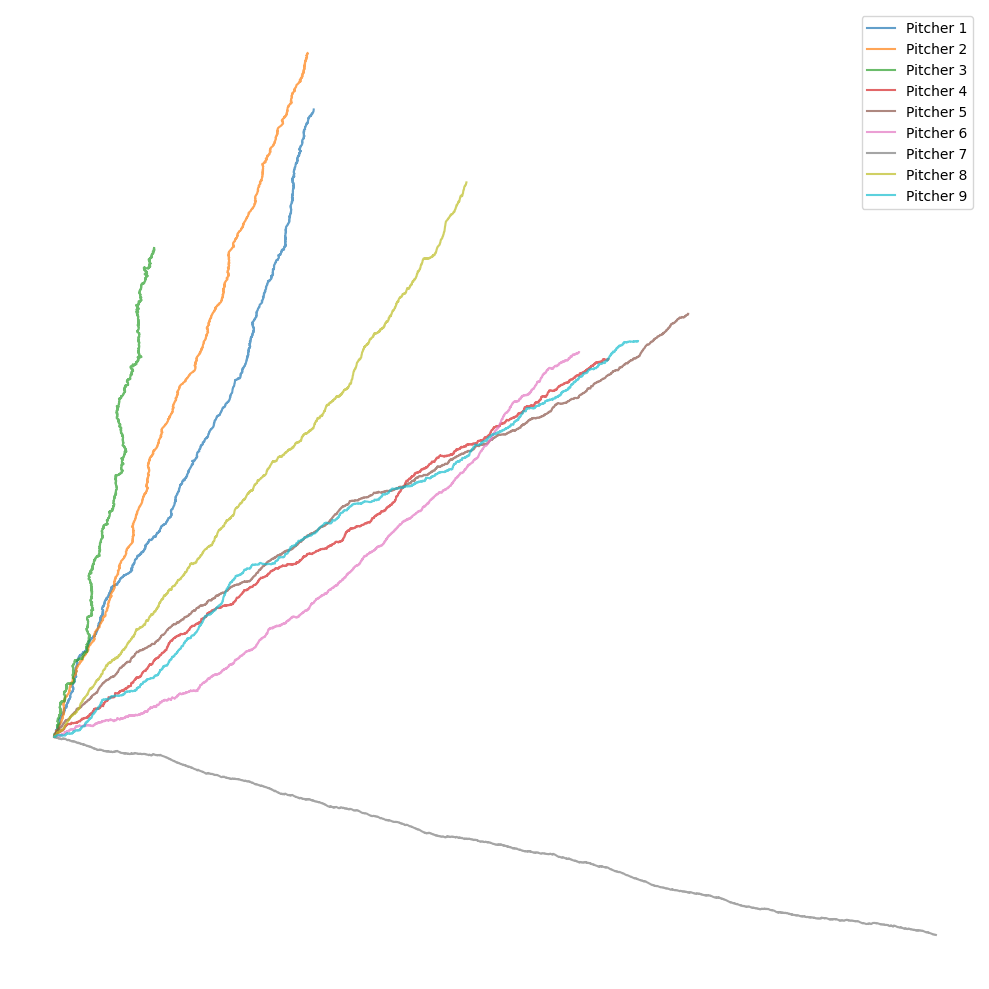

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure no NaN values in pitch types
pitch_types = data["pitch_type"].dropna().unique()

# Generate angles for each pitch type
angles = np.linspace(0, 2 * np.pi, len(pitch_types), endpoint=False)
np.random.shuffle(angles)  # Shuffle angles for an even distribution

# Map each pitch type to a specific angle
pitch_angle_map = {pitch: angle for pitch, angle in zip(pitch_types, angles)}

# Prepare a figure
fig, ax = plt.subplots(figsize=(10, 10))

# Use a colormap to assign a unique color to each of the nine pitchers
pitcher_colors = plt.cm.tab10(np.linspace(0, 1, 9))

# Iterate over the first nine pitchers in pitcher_counts
for i, (pitcher_id, _) in enumerate(pitcher_counts.items()):
    if i >= 9:  # Only plot for the first 9 pitchers
        break
    
    # Filter the dataset for the selected pitcher and ensure pitch_type is not null
    pitcher_data = data[(data["pitcher"] == pitcher_id) & (data["pitch_type"].notnull())]
    
    # Extract pitch sequences as a single continuous sequence for the season
    pitch_sequence = pitcher_data["pitch_type"].values

    x, y = 0, 0  # Starting position for the walk
    xs, ys = [x], [y]  # Lists to store the x and y coordinates

    for pitch in pitch_sequence:
        if pitch in pitch_angle_map:
            angle = pitch_angle_map[pitch]
            x += np.cos(angle)  # Move in the direction determined by the pitch type's angle
            y += np.sin(angle)
            xs.append(x)
            ys.append(y)

    # Plot the walk for the pitcher with the unique color
    ax.plot(xs, ys, marker=None, linestyle='-', color=pitcher_colors[i], alpha=0.7, label=f'Pitcher {i+1}')

ax.legend(loc='upper right')
ax.axis('off')  # Turn off the axis for a cleaner look

plt.tight_layout()
plt.savefig("pitching_sequences_all_pitchers.png")
